*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Excitatory-Inhibitory Neural Network with Lava

**Motivation**: In this tutorial, we will build a Lava Process for a neural networks of excitatory and inhibitory neurons (E/I network). <br>
E/I networks are a fundamental example of neural networks mimicking the structure of the brain and exhibiting rich dynamical behavior. <br>
We will investigate some of their dynamical properties for different single neuron dynamics as well as dynamical states. Especially the transition to a critical state which can be harnessed in reservoir computing will be of interest as well as self-balancing and the role of the recurrently generated activations in this. <br>

#### This tutorial assumes that you:
- have the [Lava framework installed](../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")

#### This tutorial gives a bird's-eye view of
- how with Lava you can implement a simple E/I Network Lava Process
- hot to define and select multiple ProcessModels for the E/I Network, based on Rate and [Leaky Integrate-and-Fire (LIF)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") neurons
- how to use tags to chose between different ProcessModels when running the Process

(Add diagram)

#### E/I Network

From bird's-eye view, an E/I network is a recurrently coupled network of neurons consisting of two populations of neurons.<br>
Since positive couplings (excitatory synapses) alone lead to a positive feedback loop ultimately causing a divergence in the activity of the network, appropriate negative couplings (inhibitory synapses) need to be introduced to counterbalance this effect.<br>
Additionally, we here require a separation of the neurons into two classes (the populations): Neurons can either be inhibitory or excitatory. <br>
Such networks exhibit different dynamical states. By introducing a control parameter we can switch between these states and simultaneously alter the response properties of the network. <br>
Our description so far has been agnostic towards the single neuron model that governs the dynamical behavior of the network. <br>
In the notebook below, we introduce two incarnations of E/I networks with different single neuron models: Rate and LIF neurons. <br>
By providing a utility functions that maps the weights from rate to LIF networks, we can retain hallmark properties of the dynamic in both networks.
<br>
Technically, the abstract E/I network is implemented via a LavaProcess, the concrete behavior - Rate and LIF dynamics - is realized with different ProcessModels.<br>

#### General imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### E/I Network Lava Process
We define the structure of the E/I Network Lava Process class. <br>

In [2]:
# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

In [3]:
class EINetwork(AbstractProcess):
    """Network of recurrently connected neurons
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        shape_exc = kwargs.pop("shape_exc", (1,))
        bias_exc = kwargs.pop("bias_exc", 1)
        shape_inh = kwargs.pop("shape_inh", (1,))
        bias_inh = kwargs.pop("bias_inh", 1)
        # Factor controlling strength of inhibitory synapses relative to excitatory synapses
        self.g_factor = kwargs.pop("g_factor", 4)
        # Factor controlling response properties of network.
        # Larger q_factor -> longer lasting effect of provided input
        self.q_factor = kwargs.pop("q_factor", 1)
        weights = kwargs.pop("weights")
        
        full_shape = shape_exc + shape_inh
        
        self.state = Var(shape=(full_shape,), init=0)
        # Variable for possible alternative state
        self.state_alt = Var(shape=(full_shape,), init=0)
        # Biases provided to neuros
        self.bias_exc = Var(shape=(shape_exc,), init=bias_exc)
        self.bias_inh = Var(shape=(shape_inh,), init=bias_inh)
        self.weights = Var(shape=(full_shape, full_shape), init=weights)

        # Ports for receiving input or sending output
        self.inport = InPort(shape=(full_shape,))
        self.outport = OutPort(shape=(full_shape,))
    
    @staticmethod    
    def generate_gaussian_weights(q_factor, g_factor, shape_exc, full_shape):
        '''Generate connectivity drawn from a Gaussian distribution with mean 0
        and std of q_factor ** 2  * sqrt(full_shape).
        W[i, j] is connection weight from pre-synaptic neuron j to post-synaptic neuron i
        '''
        # Set scaled standard deviation of recurrent weights
        J = q_factor**2 / (2 * np.sqrt(full_shape))
        weights = np.random.normal(0, J,
                                       (full_shape, full_shape))
            
        # Impose constraint that neurons can **either** be excitatory (positive weight)
        # **or** inhibitory (negative weight)
        exc_conns = np.full(weights.shape, True)
        exc_conns[:, shape_exc:] = False # Set entries for inhibitory neurons to False
        inh_conns = np.invert(exc_conns)
            
        mask_pos_weights = (weights > 0)
        mask_neg_weights = (weights < 0)

        # Set negative weights of exciatory neurons to zero and similarly for inhibitory neurons -> induce sparsity
        weights[mask_neg_weights * exc_conns] = 0
        weights[mask_pos_weights * inh_conns] = 0

        # We finally need to increase the inhibitory weights by a factor to control balance
        weights[inh_conns] *= g_factor
            
        return weights

#### ProcessModels for Python execution

In [4]:
# Import parent classes for ProcessModels for Hierarchical Processes
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.model.sub.model import AbstractSubProcessModel

# Import execution protocol
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol

# Import decorators
from lava.magma.core.decorator import implements, tag, requires

### Rate neurons
We next turn to the different implementations of the E/I Network.
We start with a rate network obeying the equation
\begin{equation}
    \tau\dot{r} =  -r + W \phi(r) + I_{\mathrm{bias}}.
\end{equation}
The rate or state $r$ is a vector containing the excitatory and inhibitory populations. <br>
The non-linearity $\phi$ is chosen to be the error function. <br> 
The dynamics consists of a dampening part ($-r$), a part modelling the recurrent connectivity ($ W \phi(r)$)
 and an external bias ($I_{\mathrm{bias}})$. <br>
 We discretize the equation as follows:
 \begin{equation}
    r(i + 1) = (1 - dr) \odot r(i) + W \phi(r(i)) \odot dr + I_{\mathrm{bias}} \odot dr
\end{equation}
Potentially different time scales in the neuron dynamics of excitatory and inhibitory neurons as well as different bias currents for these subpopulations are encoded in the vectors $dr$ and $I_{\mathrm{bias}}$. We use the error function as non-linearity $\phi$.

In [5]:
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.resources import CPU
from lava.magma.core.model.model import AbstractProcessModel

from scipy.special import erf

@implements(proc=EINetwork, protocol=LoihiProtocol)
@tag('rate_neurons') # tag allows for easy selection of ProcessModel in case multiple are defined
@requires(CPU)
class RateEINetworkModel(PyLoihiProcessModel):

    outport: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    inport: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)    
    state : np.ndarray = LavaPyType(np.ndarray, float)
    state_alt : np.ndarray = LavaPyType(np.ndarray, float)
    bias_exc : np.ndarray = LavaPyType(np.ndarray, float)
    bias_inh : np.ndarray = LavaPyType(np.ndarray, float)
    weights : np.ndarray = LavaPyType(np.ndarray, float)

    def __init__(self, proc):
        super().__init__(proc_params=proc)
        
        self.dr_exc = proc.get('dr_exc')
        self.dr_inh = proc.get('dr_inh')
        
        self.shape_exc = proc.get('shape_exc')
        self.shape_inh = proc.get('shape_inh')
        
        self.proc = proc
        
        self.got_decay = False
        self.got_bias = False
        self.weights_scaled = False
        
    def get_decay(self):
        '''Construct decay factor
        '''
        dr_full = np.array([self.dr_exc] * self.shape_exc + [self.dr_inh] * self.shape_inh)
        self.decay = 1 - dr_full
        
        self.got_decay= True
        
    def get_bias(self):
        '''Construce biases
        '''
        self.bias_full = np.hstack([self.bias_exc, self.bias_inh])
        self.got_bias = False 
        
    def scale_weights(self):
        '''Scale the weights with integration time step
        '''
        
        self.weights[:, self.shape_exc:] *= self.dr_exc
        self.weights[:, :self.shape_exc] *= self.dr_inh
        self.proc.overwrite('weights', self.weights)
        
        self.weights_scaled = True
        
    def state_update(self, state):
        """Update network state according to 
            r[i + 1] = (1 - dr)r[i] + Wr[i]*r*dr + bias*dr
        """
        state_new = self.decay * state # decay state
        state_new += self.bias_full # add bias
        state_new += self.weights @ erf(state) # add recurrent input
        return state_new
    
    def run_spk(self):
        """The run function that performs the actual computation during
        execution orchestrated by a PyLoihiProcessModel using the
        LoihiProtocol.
        """
        
        if not self.got_decay:
            self.get_decay()
            
        if not self.got_bias:
            self.get_bias()
            
        if not self.weights_scaled:
            self.scale_weights()
        
        a_in = self.inport.recv()
        self.state = self.state_update(self.state) + a_in
        self.outport.send(self.state)
        

#### Defining the parameters for the network
Next, we need to constrain the network with the needed parameters. <br>
First, we define the dimensionality of the network. Since - given a suitable parameter regime - the neurons in an E/I network tend decouple, we identify the dimensionality with the total number of neurons in the network. <br>
Moreover, we need to set the parameters for the excitatory and inhibitory neurons
For the recurrent connectivity we employ the generation method defined in the class. <br>
The weights must *balance* the network, i.e. the average recurrent input to a neuron must be less or equal than $0$.  Otherwise, the network activity is caught up in a positive feedback loop and diverges. <br>
We here follow the common choice that the ratio between the number of excitatory and inhibitory neurons equals $4$ and that the connection probability between two arbitrary neurons is identical. <br>
Since the connection probability between two arbitrary neurons is equal, we therefore need to increase the strength of the inhibitory weights, the `g_factor`, to at least $4$. We choose $6$ to place the network in the inhibition dominated regime. <br>
Finally, we set a parameter that controls the response properties of the network by scaling up the recurrent weights, the `q_factor`.

In [6]:
# Fix randomness
np.random.seed(1234)

# Dimensionality of network
dim = 300
shape = (dim,)

# We represented the dimensionality by 400 neurons. As stated above 80% of the neurons will be excitatory
num_neurons_exc = int(dim * 0.8)
num_neurons_inh = dim - num_neurons_exc

# Single neuron paramters
# Bias_mant is set to make the neuron spike
params_exc = {
    "shape_exc": num_neurons_exc,
    "dr_exc": 0.01,
    "bias_exc": 0.075}

params_inh = {
    "shape_inh": num_neurons_inh,
    "dr_inh": 0.01,
    "bias_inh": 0.075}

# Inhibition-exciation balance for scaling inhibitory weights to maintain balance (4 times as many excitatory neurons)
g_factor = 4.5

# Factor controlling the
q_factor = 1

# Parameters Paramters for E/I network
network_params_balanced = {}

network_params_balanced.update(params_exc)
network_params_balanced.update(params_inh)
network_params_balanced['g_factor'] = g_factor
network_params_balanced['q_factor'] = q_factor
network_params_balanced['weights'] = EINetwork.generate_gaussian_weights(q_factor, g_factor, num_neurons_exc, dim)

#### Execution and Results

In [7]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes
from lava.proc.io import sink, source
from lava.proc.monitor.process import Monitor

# Configurations for execution
num_steps = 1000
rcfg = Loihi1SimCfg(select_tag='rate_neurons')
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes
network_balanced = EINetwork(**network_params_balanced)
state_monitor = Monitor()

state_monitor.probe(target=network_balanced.state,  num_steps=num_steps)

# Run the network
network_balanced.run(run_cfg=rcfg, condition=run_cond)
states_balanced = state_monitor.get_data()[network_balanced.name][network_balanced.state.name]
network_balanced.stop()

#### Visualizing the acitvity
We first have a look at the trajectories of the neurons in the network.

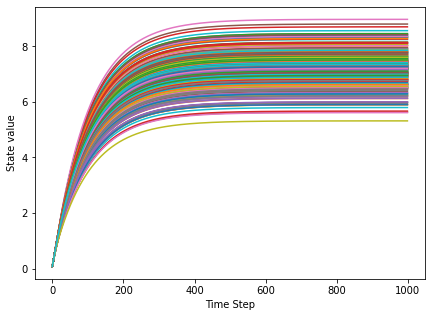

In [8]:
plt.figure(figsize=(7,5))
plt.xlabel('Time Step')
plt.ylabel('State value')
plt.plot(states_balanced)
plt.show()

We observe that after an initial period the network settles in a fixed point. As it turns out, this fixed point is stable: After a small perturbation, the network returns to this state.<br>
Such a network is unfit for performing meaningful computations, the dynamics is low-dimensional and rather poor.<br>
To better understand this, we have to apply an additional analysis.

#### Further analysis
A characteristic quantity of the network activity is the *auto-correlation function* $c(\tau)$. <br>
With this function, one can assess the *memory* of the network. <br>
Denoting the (temporally averaged) network activity by $a$, the *auto-covariance function* is the variance (here denoted $\mathrm{Cov}(\cdot, \cdot)$) of $a$ with a time shifted version of itself:
\begin{equation}
    c(\tau) = \mathrm{Cov}(a(t), a(t+\tau))
\end{equation}
This means for positive $\tau$ the value of the auto-covariance function gives a measure for the similarity of the network state $a(t)$ and $a(t+\tau)$. <br>
By comparing $c(\tau)$ with $c(0)$, we may assess the *memory* a network has of its previous states after $\tau$ time steps.<br>
Note that the auto-covariance function is not normalised!<br>
Due to this, we may derive further information about the network state: If $c(0)$ is small (in our case $<< 1$), the network acitivty does not exhibit a huge temporal variety across neurons and thus the networks dynamics are unable to perform meaningful computations.

In [9]:
def auto_cov_fct(acts, max_lag=100, offset=200):
    """Auto-correlation function of parallel spike trains
    
    Parameters
    ----------
    
    acts : np.ndarray shape (timesteps, num_neurons)
        Activity of neurons, a spike is indicated by a one    
    max_lag : int
        Maximal lag for compuation of auto-correlation function
        
    Returns:
    
    lags : np.ndarray
        lags for auto-correlation function
    auto_corr_fct : np.ndarray
        auto-correlation function
    """
    acts = acts[offset:] # disregard time steps at beginning -> network not setted yet
    assert max_lag < acts.shape[0], 'Maximal lag must be smaller then total number of time points'
    num_neurons = acts.shape[1]
    acts -= np.mean(acts, axis=0) # temporal averaging
    auto_corr_fct = np.zeros(2 * max_lag + 1)
    lags = np.linspace(-1 * max_lag, max_lag, 2 * max_lag + 1, dtype=int)
    
    for i, lag in enumerate(lags):
        shifted_acts = np.roll(acts, shift=lag, axis=0)
        auto_corrs = np.zeros(acts.shape[0])
        for j, act in enumerate(acts):
            auto_corrs[j] = np.dot(act - np.mean(act),
                                   shifted_acts[j] - np.mean(shifted_acts[j]))/num_neurons
        auto_corr_fct[i] = np.mean(auto_corrs)
        
    return lags, auto_corr_fct

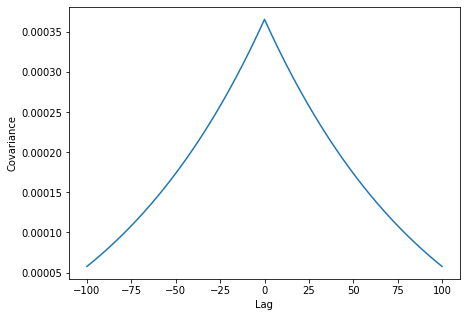

In [10]:
lags, ac_fct_balanced = auto_cov_fct(acts=states_balanced)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Covariance')
plt.plot(lags, ac_fct_balanced)
plt.show()

As expected, there is covariance has its maximum at a time lag of $0$. <br>
Examining the covariance function, we first note its values are small ($<<1$) implying low dimensional dynamics of the network. <br>
This fits our observation made above on the grounds of the display of the time-resolved activity. <br>
Moreover, we see a quick decay of the covariance with time steps implying a short memory of the network.

#### Controlling the network
We see that the states of the neurons quickly converge to a fixed point: the network does not exhibit any non-trivial behavior. <br>
The situation is even worse: One can show that this fixed point is the only fixed point of the system. This means, that after a perturbation of the network, the activity quickly relapses to the stable state. Hence, the network is incapable of performing any meaningful computation. <br>
The reason for this fixed point is, that the dampening part dominates the dynamical behavior - we need to increase the weights! <br>
This we can achieve by increasing the `q_factor`.

In [11]:
# Defining new q_factor
q_factor = 5

# Changing the strenghts of the recurrent connections
network_params_critical = network_params_balanced.copy()
network_params_critical['q_factor'] = q_factor
network_params_critical['weights'] = EINetwork.generate_gaussian_weights(q_factor, g_factor, num_neurons_exc, dim)


# Configurations for execution
num_steps = 1000
rcfg = Loihi1SimCfg(select_tag='rate_neurons')
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes
network_critical = EINetwork(**network_params_critical)
state_monitor = Monitor()

state_monitor.probe(target=network_critical.state,  num_steps=num_steps)

# Run the network
network_critical.run(run_cfg=rcfg, condition=run_cond)
states_critical = state_monitor.get_data()[network_critical.name][network_critical.state.name]
network_critical.stop()

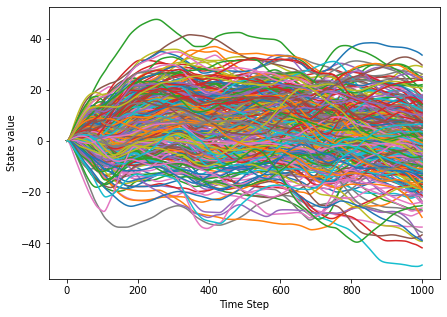

In [12]:
plt.figure(figsize=(7,5))
plt.xlabel('Time Step')
plt.ylabel('State value')
plt.plot(states_critical)
plt.show()

We find that after increasing the `q_factor`, the network shows a very different behavior. The stable fixed point is gone, instead we observe chaotical network dynamics: <br>
The single neuron trajectories behave unpredictably and fluctuate widely, small alterations would lead to completely different states.

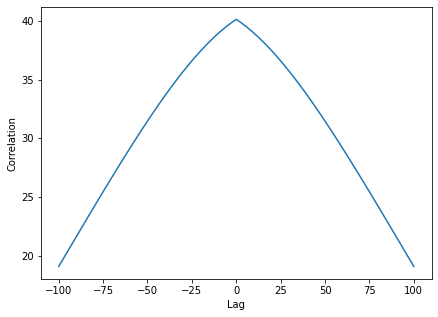

In [13]:
lags, ac_fct_critical = auto_cov_fct(acts=states_critical)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct_critical)
plt.show()

We moreover see that for positive time lags the auto-covariance function still is large. <br>
This means that the network has memory of its previous states: The state at a given point in time influences strongly the subsequent path of the trajectories of the neurons. <br>
Such a network is able to perform meaningful computation.

### LIF Neurons
We now turn to a E/I networks implementing its dynamic behavior with leaky integrate-and-fire neurons. <br>
For this, we harness the concepts of Hierarchical Lava Processes and SubProcessModels. These allow us to avoid implementing everything ourselves, but rather to use already defined Processes and their ProcessModels to build more complicated programs. <br>
We here use the behavior defined for the [LIF](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") and [Dense](https://github.com/lava-nc/lava/tree/main/src/lava/proc/dense "Lava's Dense Connectivity") Processes, we define the behavior of the E/I Network Process. <br>
Moreover, we would like to place the LIF E/I network in a similar dynamical regime as the rate network. This is a difficult task since the underlying single neurons dynamics are quite different. We here provide an approximate conversion function that allows for a parameter mapping and especially qualitatively retains properties of the auto-covariance function. <br>
With the implementation below, we may either pass LIF specific parameters directly  **or** use the same parameters needed for instantiating the rate E/I network and then convert them automatically.<br>

In [14]:
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF
from convert_params import convert_rate_to_lif_params

@implements(proc=EINetwork, protocol=LoihiProtocol)
@tag('lif_neurons')
class SubEINetworkModel(AbstractSubProcessModel):
    def __init__(self, proc):
        
        convert = proc.proc_params.get('convert', False)
        
        if convert:
            proc_params = proc.proc_params._parameters
            lif_params = SubEINetworkModel.convert_rate_to_lif_params(**proc_params)
            
            for key, val in lif_params.items():
                try:
                    proc.proc_params.__setitem__(key, val)
                except KeyError:
                    if key == 'weights':
                        # weights need to be updated
                        proc.proc_params._parameters[key] = val
                    else:
                        continue
                
        # Fetch values for excitatory neurons or set default
        shape_exc = proc.proc_params.get('shape_exc')
        shape_inh = proc.proc_params.get('shape_inh')
        du_exc = proc.proc_params.get('du_exc')
        dv_exc = proc.proc_params.get('dv_exc')
        vth_exc = proc.proc_params.get('vth_exc')
        bias_mant_exc = proc.proc_params.get('bias_exc')
        bias_exp_exc = proc.proc_params.get('bias_exp_exc', 0)
        
        
        # Fetch values for inhibitory neurons or set default
        du_inh = proc.proc_params.get('du_inh')
        dv_inh = proc.proc_params.get('dv_inh')
        vth_inh = proc.proc_params.get('vth_inh')
        bias_mant_inh = proc.proc_params.get('bias_inh')
        bias_exp_inh = proc.proc_params.get('bias_exp_inh', 0)
        
        # Create parameters for full network
        du_full = np.array([du_exc] * shape_exc
                           + [du_inh] * shape_inh)
        dv_full = np.array([dv_exc] * shape_exc
                           + [dv_inh] * shape_inh)
        vth_full = np.array([vth_exc] * shape_exc 
                            + [vth_inh] * shape_inh)
        bias_mant_full = np.array([bias_mant_exc] * shape_exc 
                                  + [bias_mant_inh] * shape_inh)
        bias_exp_full = np.array([bias_exp_exc] * shape_exc +
                                 [bias_exp_inh] * shape_inh)
        weights = proc.weights.get('value')
        weight_exp = proc.proc_params.get('weight_exp', 0)

        proc.weights = weights
        
        full_shape = shape_exc + shape_inh

        # Instantiate LIF and Dense Lava Processes
        self.lif = LIF(shape=(full_shape,),
                       du=du_full,
                       dv=dv_full,
                       vth=vth_full,
                       bias_mant=bias_mant_full,
                       bias_exp=bias_exp_full)

        print(weight_exp)
        self.dense = Dense(weights=weights,
                           weight_exp=weight_exp)
            
            
        # Recurrently connect neurons to E/I Network
        self.lif.s_out.connect(self.dense.s_in)
        self.dense.a_out.connect(self.lif.a_in)

        # Connect incoming activation to neurons and elicited spikes to ouport
        proc.inport.connect(self.lif.a_in)
        self.lif.s_out.connect(proc.outport)
        
        # Alias v with state and u with state_alt
        proc.vars.state.alias(self.lif.vars.v)
        proc.vars.state_alt.alias(self.lif.vars.u)
        
    def convert_rate_to_lif_params(**kwargs):
        '''Convert rate parameters to LIF parameters.
        The mapping is based on A unified view on weakly correlated recurrent network, Grytskyy et al. 2013
        
        Parameters
        ----------
        kwargs : dict
            Parameter dictionary for rate network
        
        Returns
        -------
        lif_network_dict : dict
            Parameter dictionary for LIF network
        '''       
    
        return convert_rate_to_lif_params(**kwargs)

#### Execution and Results

In [15]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes
from lava.proc import io

from lava.proc.dense.models import PyDenseModelFloat
from lava.proc.lif.models import PyLifModelFloat


# Configurations for execution
num_steps = 1000
run_cond = RunSteps(num_steps=num_steps)

class CustomRunConfigFloat(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # customize run config to always use float model for io.sink.RingBuffer
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        if isinstance(proc, LIF):
            return PyLifModelFloat
        elif isinstance(proc, Dense):
            return PyDenseModelFloat
        else:
            return super().select(proc, proc_models)
        
rcfg = CustomRunConfigFloat(select_tag='lif_neurons', select_sub_proc_model=True)

# Convert the rates
# Instantiating network and IO processes
# network_params_balanced['convert'] = True
lif_network_balanced = EINetwork( **network_params_balanced, convert=True)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)
monitor_v = Monitor()
monitor_u = Monitor()

lif_network_balanced.outport.connect(outport_plug.a_in)
monitor_v.probe(target=lif_network_balanced.state,  num_steps=num_steps)
monitor_u.probe(target=lif_network_balanced.state_alt,  num_steps=num_steps)

lif_network_balanced.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_balanced = outport_plug.data.get()
data_v_balanced = monitor_v.get_data()[lif_network_balanced.name][lif_network_balanced.state.name]
data_u_balanced = monitor_u.get_data()[lif_network_balanced.name][lif_network_balanced.state_alt.name]

lif_network_balanced.stop()

0


#### Visualizing the activity
First, we visually inspect to spiking activity of the neurons in the network.<br>
To this end, we display neurons on the vertical axis and mark the time step when a neuron spiked.

In [16]:
def raster_plot(spks, stride=6, fig=None, color='b'):
    """Generate raster plot of spiking activity
    
    Parameters
    ----------
    
    spks : np.ndarray shape (num_neurons, timesteps)
        Spiking activity of neurons, a spike is indicated by a one    
    stride : int
        Stride for plotting neurons
    """
    num_time_steps = spks.shape[1]
    assert stride < num_time_steps, "Stride must be smaller than number of time steps"
    
    time_steps = np.arange(0, num_time_steps, 1)
    if fig is None:
        fig = plt.figure(figsize=(10,5))
    timesteps = spks.shape[1]
    
    plt.xlim(-1, num_time_steps)
    plt.yticks([])
    
    plt.xlabel('Time steps')
    plt.ylabel('Neurons')
    
    for i in range(0, dim, stride):
        spike_times = time_steps[spks[i] == 1]
        plt.plot(spike_times,
                 i * np.ones(spike_times.shape),
                 linestyle=' ',
                 marker='o',
                 markersize=1.5,
                 color=color)
        
    return fig       

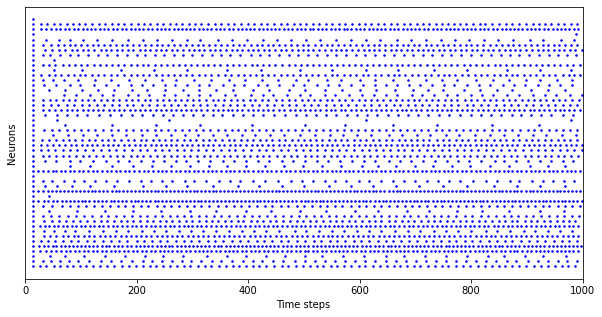

In [17]:
fig = raster_plot(spks=spks_balanced)

After an initial synchronous burst (all neurons are simultaneously driven to the threshold by the external current), we observe an immediate decoupling of the single neuron activities due to the recurrent connectivity.<br>
Overall, we see a heterogeneous network state with asynchronous as well as synchronous spiking across neurons. <br>
This network state resembles qualitatively the fixed point observed above for the rate network. <br>
Before we turn to the study of the auto-covariance we need to address a subtlety in the comparison of spiking and rate network. <br>
Comparing spike trains and rates directly is difficult due dynamics of single spiking neurons: Most of the time, a neuron does not spike! <br>
To overcome this problem and meaningfully compare quantities like the auto-covariance function, we follow the usual approach and bin the spikes. This means, we apply a sliding box-car window of a given length and count at each time step the spikes in that window to obtain an estimate of the rate. <br>

In [18]:
window = np.ones(30) # window size of 30 time steps
binned_sps_balanced = np.asarray([np.convolve(spks_balanced[i], window) for i in range(dim)])

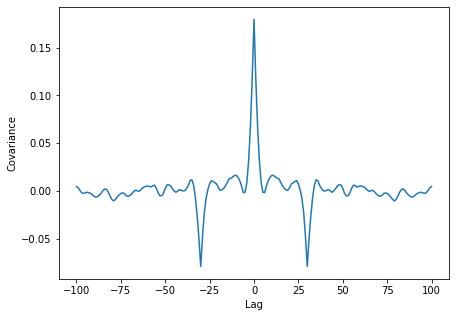

In [19]:
lags, ac_fct = auto_cov_fct(acts=binned_sps_balanced.T)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Covariance')
plt.plot(lags, ac_fct)

Examining the auto-covariance function, we first note that again the overall values are small. Moreover, we see that for non-vanishing time lags the auto-covariance function quickly decay.<br>
This means that the network has no memory of its previous states: Already after few time step we lost almost all information of the previous network state, former states leave little trace in the overall network activity. <br>
Such a network is unfit to perform meaningful computation.

#### Controlling the network
Next, we pass the rate network parameters for which we increased the `q_factor` to the spiking E/I network.<br>
Dynamically, this increase again should result in a fundamentally different network state.

In [20]:
num_steps = 1000
rcfg = CustomRunConfigFloat(select_tag='lif_neurons', select_sub_proc_model=True)
run_cond = RunSteps(num_steps=num_steps)

# Creating new new network with changed weights
lif_network_critical = EINetwork(**network_params_critical, convert=True)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)
monitor_v = Monitor()
monitor_u = Monitor()

lif_network_critical.outport.connect(outport_plug.a_in)
monitor_v.probe(target=lif_network_critical.state,  num_steps=num_steps)
monitor_u.probe(target=lif_network_critical.state_alt,  num_steps=num_steps)

lif_network_critical.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_critical = outport_plug.data.get()
data_v_critical = monitor_v.get_data()[lif_network_critical.name][lif_network_critical.state.name]
data_u_critical = monitor_u.get_data()[lif_network_critical.name][lif_network_critical.state_alt.name]

lif_network_critical.stop()

0


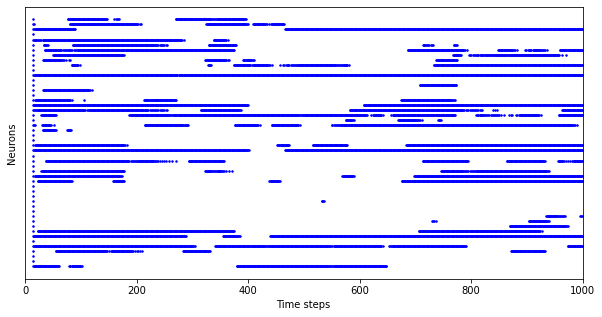

In [21]:
fig = raster_plot(spks=spks_critical)

Here we see a qualitatively different network activity where the recurrent connections play a more dominant role: <br>
At seemingly random times, single neurons enter into active states of variable length. <br>
Next, we have a look at the auto-covariance function of the network, especially in direct comparison with the respective function of the rate network.

In [22]:
window = np.ones(30)
binned_sps_critical = np.asarray([np.convolve(spks_critical[i], window) for i in range(dim)])
lags, ac_fct_lif_critical = auto_cov_fct(acts=binned_sps_critical.T)

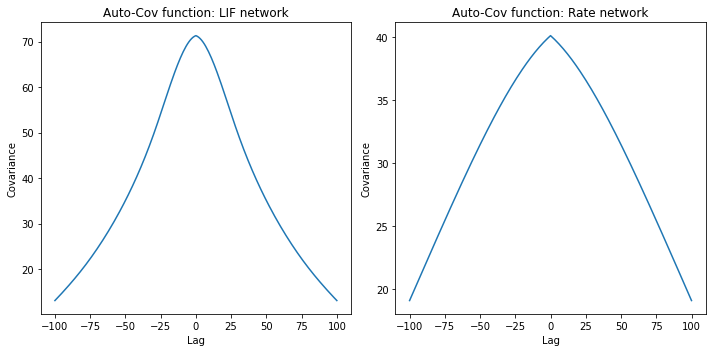

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(lags, ac_fct_lif_critical)
ax1.set_title('Auto-Cov function: LIF network')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Covariance')
ax2.plot(lags, ac_fct_critical)
ax2.set_title('Auto-Cov function: Rate network')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Covariance')
plt.tight_layout()

We observe in the auto-covariance function of the LIF network a slowly decay, akin to the rate network. <br>
Even though both auto-covariance functions are not identical, they qualitatively match in that both network exhibit long-lasting temporal correlations and an activity at the edge of chaos. <br>
This implies that both network are in a suitable regime for computation, e.g. in the context of reservoir computing.

#### Self balancing of the network
After having observed these two radically different dynamical states in the LIF network, we next turn to the question how they come about. <br>
Besides the external currents driving the neurons above threshold and causing the neurons to spike, the recurrently provided activations to the neuron determine the dynamics. <br>
We now examine these activations. Since we know the spike times of the individual neurons as well as the recurrent weights, we may calculate the excitatory, inhibitory as well as total activiation provided to each neuron in both networks.

In [24]:
def calculate_activation(weights, spks, num_exc_neurons):
    """Calculate excitatory, inhibitory and total activation to neurons
    
    Parameters
    ----------
    
    weights : np.ndarray (num_neurons, num_neurons)
        Weights of recurrent connections
    spks : np.ndarray (num_neurons, num_time_steps)
        Spike times of neurons, 0 if neuron did not spike, 1 otherwise
    num_exc_neurons : int
        Number of excitatory neurons
        
    Returns
    -------
    
    activation_exc : np.ndarray (num_neurons, num_time_steps)
        Excitatory activation provided to neurons
    activation_inh : np.ndarray (num_neurons, num_time_steps)
        Inhibitory activation provided to neurons
    activations_total : np.ndarray (num_neurons, num_time_steps)
        Total activation provided to neurons
    """
    
    weights_exc = weights[:, :num_exc_neurons]
    weights_inh = weights[:, num_exc_neurons:]
    
    spks_exc = spks[:num_exc_neurons]
    spks_inh = spks[num_exc_neurons:]
    
    activation_exc = np.matmul(weights_exc, spks_exc)
    activation_inh = np.matmul(weights_inh, spks_inh)
    
    activation_total = activation_exc + activation_inh
    
    return activation_exc, activation_inh, activation_total

Since the network needs some time to settle in it's dynamical state, we discard the first $200$ time steps.

In [25]:
offset = 200

act_exc_balanced, act_inh_balanced, act_tot_balanced \
    = calculate_activation(lif_network_balanced.proc_params.get('weights'),
                          spks_balanced[:,offset:],
                          network_params_balanced['shape_exc'])

act_exc_critical, act_inh_critical, act_tot_critical \
    = calculate_activation(lif_network_critical.proc_params.get('weights'),
                          spks_critical[:,offset:],
                          network_params_balanced['shape_exc'])

First, we look at the distribution of activation of a random neuron in both network states.

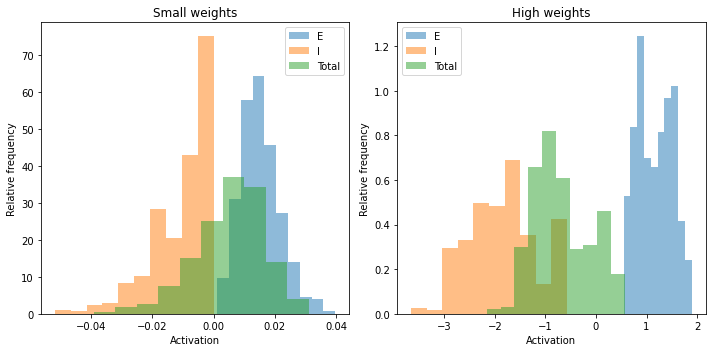

In [26]:
rnd_neuron = 4

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Small weights')
ax1.set_xlabel('Activation')
ax1.set_ylabel('Relative frequency')
ax1.hist(act_exc_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='E')
ax1.hist(act_inh_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='I'),
ax1.hist(act_tot_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='Total')
ax1.legend()

ax2.set_title('High weights')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Relative frequency')
ax2.hist(act_exc_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='E')
ax2.hist(act_inh_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='I')
ax2.hist(act_tot_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='Total')
ax2.legend()

plt.tight_layout()
plt.show()

Next, we plot the distribution of the temporal average:

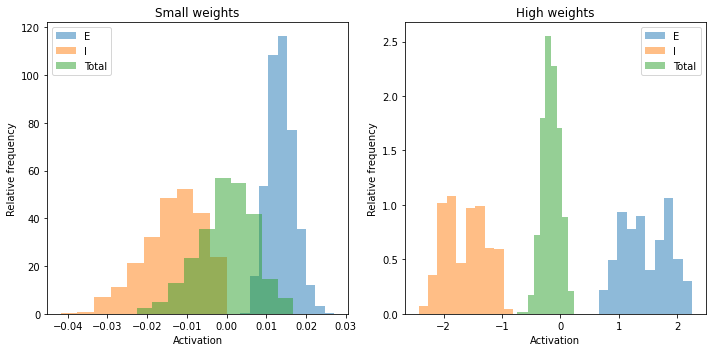

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Small weights')
ax1.set_xlabel('Activation')
ax1.set_ylabel('Relative frequency')
ax1.hist(act_exc_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='E')
ax1.hist(act_inh_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='I'),
ax1.hist(act_tot_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='Total')
ax1.legend()

ax2.set_title('High weights')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Relative frequency')
ax2.hist(act_exc_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='E')
ax2.hist(act_inh_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='I')
ax2.hist(act_tot_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='Total')
ax2.legend()

plt.tight_layout()
plt.show()

We first note that the the total activation is close to zero with a slight shift to negative values.
This self balancing gives the networks stability and prevents the divergence of the activity. <br>
Secondly, we observe that the width of the distributions is orders of magnitude larger in the high weight case as compared to the low weight network. <br>
Finally, we look at the evolution of the mean activation over time. To this end we plot three random sample:

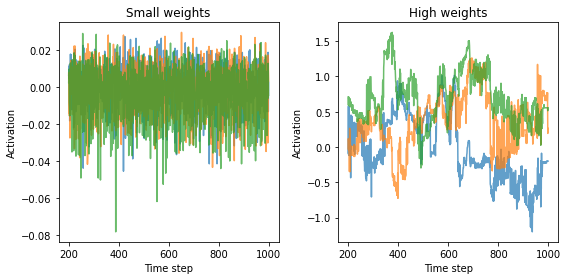

In [28]:
time_steps = np.arange(offset, num_steps, 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set_title('Small weights')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Activation')
for i in range(3):
    ax1.plot(time_steps, act_tot_balanced[i], alpha=0.7)


ax2.set_title('High weights')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Activation')
for i in range(3):
    ax2.plot(time_steps, act_tot_critical[i], alpha=0.7)

plt.tight_layout()
plt.show()

We observe, in accordance with the above histograms, that the distribution of the total activation in  the small weights case is much narrower than in the high weights network. <br>
Moreover, we see that the intrinsic time scale of the fluctuation of the total activation is very different in both networks:
In the high weights network, the fluctuation evolves on a very long time scale as compared to the other network. <br>
This implies that a neuron can sustain it's active, bursting state over longer periods of time leading to memory in the network as well as activity at the edge of chaos: the different states are caused by the *vastly different activation regimes* induced by the recurrent activity. <br>

#### Runnig a ProcessModel bit-accurate with Loihi
So far, we habe used neuron modesl and weights that are internally represented as floating point numbers. <br>
When executing the network on Loihi, however, we have to use fixed point arithmetic for the dynamics of the single neurons. Hence, the parameters need to be mapped to retain the dynamical behaviour of the network. <br>
First, we define a funcion mapping the parameters. It consists of finding an optimal scaling function as well as mapping the parameters of the LIF network.

In [32]:
def _scaling_funct(params):
    '''Find optimal scaling function for float- to fixed-point mapping.
    
    Parameter
    ---------
    params : dict
        Dictionary containing information required for float- to fixed-point mapping
        
    Returns
    ------
    scaling_funct : callable
        Optimal scaling function for float- to fixed-point conversion
    '''
    
    sorted_params = dict(sorted(params.items(), key=lambda x: np.max(np.abs(x[1]['val'])), reverse=True))
    
    
    scaling_funct = None
    
    for key, val in sorted_params.items():
        
        if val['signed'] == 's':
            signed_shift = 1
        else:
            signed_shift = 0
            
        if np.max(val['val']) == np.max(np.abs(val['val'])):
            max_abs = True
            max_abs_val = np.max(val['val'])
        else:
            max_abs = False
            max_abs_val = np.max(np.abs(val['val']))
            
        if max_abs:
            rep_val = 2**(val['bits'] - signed_shift) - 1
        else:
            rep_val = 2**(val['bits'] - signed_shift)
        
        max_shift = np.max(val['shift'])
        
        max_rep_val = rep_val * 2**max_shift
      
        if scaling_funct:
            scaled_vals = scaling_funct(val['val'])

            max_abs_scaled_vals = np.max(np.abs(scaled_vals))
            if max_abs_scaled_vals <= max_rep_val:
                continue
            else:
                p1 = max_rep_val
                p2 = max_abs_val
        
        else:
            p1 = max_rep_val
            p2 = max_abs_val         
        
        scaling_funct = lambda x: p1 / p2 * x
        
    return scaling_funct

def float2fixed_lif_parameter(params):
    '''Float- to fixed-point mapping for LIF parameters
    
    Parameters
    ---------
    lif_params : dict
        Dictionary with parameters for LIF network with floating-point ProcModel
        
    Returns
    ------
    lif_params_fixed : dict
        Dictionary with parameters for LIF network with fixed-point ProcModel
    '''
    
    scaling_funct = _scaling_funct(params)
    scaled_bias = scaling_funct(params['bias']['val'])[0]
    
    bias_exp = int(np.ceil(np.log2(scaled_bias) - 13 + 1))
    if bias_exp <=0:
        bias_exp = 0
        
    scaled_weights = scaling_funct(params['weights']['val'])
    
    
    weight_exp = int(np.ceil(np.log2(scaled_bias) - 8 + 1))
    weight_exp = np.max(weight_exp) - 6
    if weight_exp <=0:
        diff = weight_exp
        weight_exp = 0

    
    bias_mant = int(scaled_bias // 2**bias_exp)
    weights = scaled_weights.astype(np.int32)
    
    lif_params_fixed = {'vth' : int(scaling_funct(params['vth']['val'])) // 2**params['vth']['shift'][0],
                        'bias_mant': bias_mant,
                        'bias_exp': bias_exp,
                        'weights': (scaled_weights // 2 ** params['weights']['shift'][0]).astype(np.int32),
                        'weight_exp': weight_exp}
    
    return lif_params_fixed

def scaling_funct_dudv(val):
    '''Scaling function for du, dv in LIF
    '''
    
    assert val < 1, 'Passed value must be smaller than 1'
    
    return int(val * 2 ** 12)

After having defined some primitive conversion functionality we next converter the parameters for the balanced network. <br>
We need to pass the precision of the 

In [33]:
u_low = np.quantile(data_u_balanced.flatten(), 0.05)
u_high = np.quantile(data_u_balanced.flatten(), 0.95)
v_low = np.quantile(data_v_balanced.flatten(), 0.05)
v_high = np.quantile(data_v_balanced.flatten(), 0.95)

lif_params_balanced = convert_rate_to_lif_params(**network_params_critical)
weights = lif_params_balanced['weights']
bias = lif_params_balanced['bias_exc']

params = {'vth': {'bits': 17, 'signed': 'u', 'shift': np.array([6]), 'val': np.array([1])},
          'u': {'bits': 24, 'signed': 's', 'shift': np.array([0]), 'val': np.array([u_low, u_high])},
          'v': {'bits': 24, 'signed': 's', 'shift': np.array([0]), 'val': np.array([v_low, v_high])},
          'bias': {'bits': 13, 'signed': 's', 'shift': np.arange(0, 8, 1), 'val': np.array([bias])},
          'weights' : {'bits': 8, 'signed': 's', 'shift': np.arange(6,22,1), 'val': weights}}

In [34]:
mapped_params = float2fixed_lif_parameter(params)

In [35]:
lif_params_balanced_fixed = {'shape_exc': lif_params_balanced['shape_exc'],
                             'shape_inh': lif_params_balanced['shape_inh'],
                             'g_factor': lif_params_balanced['g_factor'],
                             'q_factor': lif_params_balanced['q_factor'],
                             'vth_exc': mapped_params['vth'],
                             'vth_inh': mapped_params['vth'],
                             'bias_exc': mapped_params['bias_mant'],
                             'bias_exp_exc': mapped_params['bias_exp'],
                             'bias_inh': mapped_params['bias_mant'],
                             'bias_exp_inh': mapped_params['bias_exp'],
                             'weights': mapped_params['weights'],
                             'weight_exp': mapped_params['weight_exp'],
                             'du_exc': scaling_funct_dudv(lif_params_balanced['du_exc']),
                             'dv_exc': scaling_funct_dudv(lif_params_balanced['dv_exc']),
                             'du_inh': scaling_funct_dudv(lif_params_balanced['du_inh']),
                             'dv_inh': scaling_funct_dudv(lif_params_balanced['dv_inh'])}

In [36]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes
from lava.proc import io

from lava.proc.dense.models import PyDenseModelBitAcc
from lava.proc.lif.models import PyLifModelBitAcc


# Configurations for execution
num_steps = 500
run_cond = RunSteps(num_steps=num_steps)

class CustomRunConfigFixed(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # customize run config to always use float model for io.sink.RingBuffer
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        if isinstance(proc, LIF):
            return PyLifModelBitAcc
        elif isinstance(proc, Dense):
            return PyDenseModelBitAcc
        else:
            return super().select(proc, proc_models)
        
rcfg = CustomRunConfigFixed(select_tag='lif_neurons', select_sub_proc_model=True)

# Convert the rates
# Instantiating network and IO processes
# network_params_balanced['convert'] = True
lif_network_balanced_fixed = EINetwork(**lif_params_balanced_fixed)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)
#monitor_v = Monitor()
#monitor_u = Monitor()

lif_network_balanced_fixed.outport.connect(outport_plug.a_in)
#monitor_v.probe(target=lif_network_balanced.state,  num_steps=num_steps)
#monitor_u.probe(target=lif_network_balanced.state_alt,  num_steps=num_steps)

lif_network_balanced_fixed.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_balanced_fixed = outport_plug.data.get()
#data_v_balanced = monitor_v.get_data()[lif_network_balanced.name][lif_network_balanced.state.name]
#data_u_balanced = monitor_u.get_data()[lif_network_balanced.name][lif_network_balanced.state_alt.name]

lif_network_balanced_fixed.stop()

4


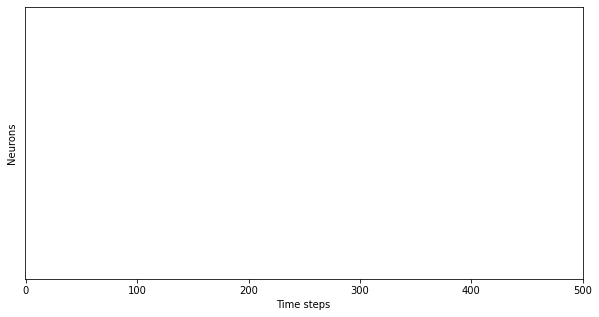

In [46]:
fig = raster_plot(spks=spks_balanced_fixed)
#fig = raster_plot(spks=spks_critical, fig=fig, color='orange')

In [38]:
for item in params.items():
    print(item[1])

{'bits': 17, 'signed': 'u', 'shift': array([6]), 'val': array([1])}
{'bits': 24, 'signed': 's', 'shift': array([0]), 'val': array([-0.0922934 ,  0.08764073])}
{'bits': 24, 'signed': 's', 'shift': array([0]), 'val': array([-1.02928298,  0.94633009])}
{'bits': 13, 'signed': 's', 'shift': array([0, 1, 2, 3, 4, 5, 6, 7]), 'val': array([0.015])}
{'bits': 8, 'signed': 's', 'shift': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), 'val': array([[ 3.11891709e-04,  0.00000000e+00,  1.14829098e-04, ...,
        -1.82994793e-04, -1.21961624e-03, -5.26498894e-04],
       [ 5.97045580e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -1.19236336e-03, -3.19021484e-03,  0.00000000e+00],
       [ 0.00000000e+00,  2.04844341e-04,  0.00000000e+00, ...,
        -2.12227116e-04, -2.13315074e-04,  0.00000000e+00],
       ...,
       [ 9.02716641e-05,  0.00000000e+00,  6.81603275e-04, ...,
         0.00000000e+00, -5.94306898e-03,  0.00000000e+00],
       [ 0.00000000e+00,  3.78251

In [47]:
lif_params_balanced_fixed

{'shape_exc': 240,
 'shape_inh': 60,
 'g_factor': 4.5,
 'q_factor': 5,
 'vth_exc': 127343,
 'vth_inh': 127343,
 'bias_exc': 3820,
 'bias_exp_exc': 5,
 'bias_inh': 3820,
 'bias_exp_inh': 5,
 'weights': array([[  39,    0,   14, ...,  -24, -156,  -68],
        [   7,    0,    0, ..., -152, -407,    0],
        [   0,   26,    0, ...,  -28,  -28,    0],
        ...,
        [  11,    0,   86, ...,    0, -757,    0],
        [   0,   48,   32, ...,    0,  -64,    0],
        [  76,    0,   37, ..., -330,  -82, -113]], dtype=int32),
 'weight_exp': 4,
 'du_exc': 286,
 'dv_exc': 40,
 'du_inh': 286,
 'dv_inh': 40}

In [48]:
a = LIF(shape=(1,), vth=127343, bias_mant=3820, bias_exp=5)

rcfg = Loihi1SimCfg(select_tag='fixed_pt')
run_cond = RunSteps(num_steps=1)

v =[]

for i in range(30):
    a.run(run_cfg=rcfg, condition=run_cond)
    
    v.append(a.v.get())
    
a.stop()

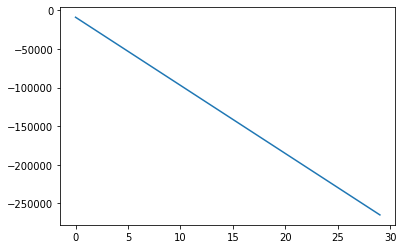

In [49]:
plt.plot(v)